# **데이터 불러오기**

In [ ]:
# google drive 연동

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# graph 한글 깨짐 방지(해당 셀 실행 후, 런타임 다시 시작 필요)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (20.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
# current work path

import os
os.chdir('/content/drive/My Drive/숨고')

In [ ]:
# data importing
import pandas as pd
import numpy as np

kospi=pd.read_csv('김준희님/1. data_2431_20220417(코스피).csv',encoding='cp949')
kosdaq=pd.read_csv('김준희님/2. data_4233_20220417(코스닥).csv',encoding='cp949')
dowjones=pd.read_csv('김준희님/3. Macrotrends-dow-jones-industrial-average-daily.csv',encoding='cp949')
sp500=pd.read_csv('김준희님/4. Macrotrends-s-p-500-index-daily.csv',encoding='cp949')
nasdaq=pd.read_csv('김준희님/5. NASDAQCOM.csv',encoding='cp949')
nikkei=pd.read_csv('김준희님/6. nikkei-225-index-historical-chart-data.csv',encoding='cp949')

FileNotFoundError: ignored

# **KOSPI**

In [ ]:
# kospi 날짜 타입 변환 
kospi = kospi[['일자','종가']]
kospi['일자'] = pd.to_datetime(kospi['일자'], format='%Y-%m-%d')
kospi = kospi.sort_values(['일자']).reset_index(drop=True)
print("kospi 원본 데이터")
print(kospi.head(8),"\n")


# kospi 기준선 및 전환선 생성
for i in range(1,26):
    kospi = pd.concat([kospi,kospi.iloc[:,-1].shift(1)],axis=1)
kospi['26일최고치'] = kospi.iloc[:,1:].apply(lambda x : np.max(x), axis=1)
kospi['26일최저치'] = kospi.iloc[:,1:].apply(lambda x : np.min(x), axis=1)
kospi['9일최고치'] = kospi.iloc[:,1:10].apply(lambda x : np.max(x), axis=1)
kospi['9일최저치'] = kospi.iloc[:,1:10].apply(lambda x : np.min(x), axis=1)
kospi['기준선'] = (kospi['26일최고치'] + kospi['26일최저치']) * 0.5
kospi['전환선'] = (kospi['9일최고치'] + kospi['9일최저치']) * 0.5

kospi = pd.concat([kospi.iloc[:,:2],kospi.iloc[:,-2:]],axis=1).iloc[25:,:].reset_index(drop=True)
print("kospi 데이터(기준선, 전환선 추가)")
print(kospi, "\n")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')

# 그래프 생성
plt.figure(figsize=(15,7))
ax = sns.lineplot(data = kospi[:300], x = '일자', y = '종가', alpha=0.5)
ax1 = sns.lineplot(data = kospi[:300], x = '일자', y = '기준선', alpha=0.5)
ax2 = sns.lineplot(data = kospi[:300], x = '일자', y = '전환선', alpha=0.5)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_ylabel("종가",fontsize = 14)
ax.set_xlabel("일자",fontsize = 14)
ax.set_title("과거 300일치 일자별 데이터 분포",fontsize=16)
ax.legend(['종가','기준선','전환선'],fontsize=10)

In [ ]:
# 년도 구간 별 분포 파악 
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(20, 10)
for i in range(4):
    ax = axes[i//2, i%2]
    df = kospi.loc[(kospi['일자'] > time_steps[i][0]) & (kospi['일자'] < time_steps[i][1])]
    sns.lineplot(y=df['종가'], x=df['일자'], ax=ax)
    sns.lineplot(y=df['기준선'], x=df['일자'], ax=ax)
    sns.lineplot(y=df['전환선'], x=df['일자'], ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}',fontsize = 16)
    ax.set_xlabel('일자',fontsize = 14)
    ax.set_ylabel('가격',fontsize = 14)
    ax.legend(['종가','기준선','전환선'],fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# 학습을 위한 train/test set 분리(과거부터 80%지점 : train set, 이후 20% : test set)
train = kospi[:round(len(kospi)*0.8)]
test = kospi[round(len(kospi)*0.8):]

# data normalization(0~1) : train set에서 normalization된 정보를 통해 test set도 normalization 진행
from sklearn.preprocessing import MinMaxScaler
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
scaler_3 = MinMaxScaler()
train_price_1 = scaler_1.fit_transform(train[['종가']])
train_price_2 = scaler_2.fit_transform(train[['기준선']])
train_price_3 = scaler_3.fit_transform(train[['전환선']])
train_scaled = pd.concat([pd.DataFrame(train_price_1),pd.DataFrame(train_price_2),pd.DataFrame(train_price_3)],axis=1)
train_scaled.columns = ['종가', '기준선', '전환선']
test_price_1 = scaler_1.transform(test[['종가']])
test_price_2 = scaler_2.transform(test[['기준선']])
test_price_3 = scaler_3.transform(test[['전환선']])
test_scaled = pd.concat([pd.DataFrame(test_price_1),pd.DataFrame(test_price_2),pd.DataFrame(test_price_3)],axis=1)
test_scaled.columns = ['종가', '기준선', '전환선']

print("train scaled result")
print(train_scaled,"\n")
print("test scaled result")
print(test_scaled,"\n")

In [ ]:
# 과거 52일을 통해 다음날 가격 예측을 위한 데이터 처리 함수
def sequential_dataset(data, label, input_window_size=52):
    input = []
    output = []
    for i in range(len(data) - input_window_size):
        input.append(np.array(data.iloc[i:i+input_window_size]))
        output.append(np.array(label.iloc[i+input_window_size]))
    return np.array(input), np.array(output)

# train set에 처리 함수 적용
train_feature = train_scaled[['종가', '기준선', '전환선']]
train_label = train_scaled['종가']
train_feature, train_label = sequential_dataset(train_feature, train_label, 52)


# train에서 validation set 분리(train set 내 과거부터 80%지점 : train set, 이후 20% : validaton set)
train_feature_split = train_feature[:round(len(train_feature)*0.8)]
train_label_split = train_label[:round(len(train_feature)*0.8)]
valid_feature = train_feature[round(len(train_feature)*0.8):]
valid_label = train_label[round(len(train_label)*0.8):]

# test set에 처리 함수 적용
test_feature = test_scaled[['종가', '기준선', '전환선']]
test_label = test_scaled['종가']
test_feature, test_label = sequential_dataset(test_feature, test_label, 52)

print("train input shape")
print(train_feature_split.shape, "\n")
print("train label shape")
print(train_label_split.shape, "\n")
print("validation input shape")
print(valid_feature.shape, "\n")
print("validation label shape")
print(valid_label.shape, "\n")
print("test input shape")
print(test_feature.shape, "\n")
print("test label shape")
print(test_label.shape, "\n")


# 그래프 생성(종가 기준 판단)
plt.figure(figsize=(15,7))
ax = sns.lineplot(data = kospi[:train_feature_split.shape[0]], x = '일자', y = '종가', alpha=0.5)
ax1 = sns.lineplot(data = kospi[train_feature_split.shape[0]:train_feature_split.shape[0] + valid_feature.shape[0]], x = '일자', y = '종가', alpha=0.5)
ax2 = sns.lineplot(data = kospi[train_feature_split.shape[0] + valid_feature.shape[0]:], x = '일자', y = '종가', alpha=0.5)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_ylabel("종가",fontsize = 14)
ax.set_xlabel("일자",fontsize = 14)
ax.set_title("train/validation/test data",fontsize=16)
ax.legend(['train set','val set','test set'],fontsize=10)

In [ ]:
# 주가 예측을 위한 모듈 import
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM,GRU,Dropout
from tensorflow.keras.optimizers import Adam

# LSTM 학습을 위한 모델 정의
lstm_model = Sequential()

lstm_model.add(LSTM(32, 
               input_shape=(train_feature_split.shape[1], train_feature_split.shape[2]), 
               activation='tanh', 
               return_sequences=True,
               kernel_initializer='glorot_normal'))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(64,
          activation='tanh',
          return_sequences=False,
          kernel_initializer='glorot_normal'))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(1))
lstm_model.summary()

In [ ]:
# LSTM 학습 옵션 정의 

opt = Adam(learning_rate=0.0001)
lstm_model.compile(loss='mean_squared_error', optimizer=opt)

# 과적합 방지를 위한 조기 종료 정의
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# 최적 모델 저장 셋팅
filename = os.path.join("김준희님/", 'KOSPI_bestmodel_LSTM.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# 모델 학습 진행
lstm_history = lstm_model.fit(train_feature_split, train_label_split, 
                    epochs=400, 
                    batch_size=64,
                    validation_data=(valid_feature, valid_label), 
                    callbacks=[early_stop, checkpoint])

In [ ]:
# model load
lstm_model.load_weights(filename)

## 위에서 분리해둔 test set에 대하여 모델 정확도 반환
print('\mean_squared_error: {:.4f}'.format(lstm_model.evaluate(test_feature, test_label))) 

y_vloss = lstm_history.history['val_loss'] # 학습 중 validation loss 저장
y_loss = lstm_history.history['loss'] # 학습 중 train loss 저장
x_len = np.arange(len(y_loss)) # 학습 완료 시점의 epoch 길이 저장

plt.figure(figsize=(10,5))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss") # validation loss에 대한 그래프 출력
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss") # train loss에 대한 그래프 출력
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# GRU 학습을 위한 모델 정의
gru_model = Sequential()

gru_model.add(GRU(32, 
               input_shape=(train_feature_split.shape[1], train_feature_split.shape[2]), 
               activation='tanh', 
               return_sequences=True,
               kernel_initializer='glorot_normal'))
gru_model.add(Dropout(0.3))

gru_model.add(GRU(64,
          activation='tanh',
          return_sequences=False,
          kernel_initializer='glorot_normal'))
gru_model.add(Dropout(0.3))

gru_model.add(Dense(1))
gru_model.summary()

In [ ]:
# GRU 학습 옵션 정의 

opt = Adam(learning_rate=0.0001)
gru_model.compile(loss='mean_squared_error', optimizer=opt)

# 과적합 방지를 위한 조기 종료 정의
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# 최적 모델 저장 셋팅
filename = os.path.join("김준희님/", 'KOSPI_bestmodel_GRU.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# 모델 학습 진행
gru_history = gru_model.fit(train_feature_split, train_label_split, 
                    epochs=400, 
                    batch_size=64,
                    validation_data=(valid_feature, valid_label), 
                    callbacks=[early_stop, checkpoint])

NameError: ignored

42/42 [==============================] - 0s 10ms/step - loss: 0.0013
\mean_squared_error: 0.0013


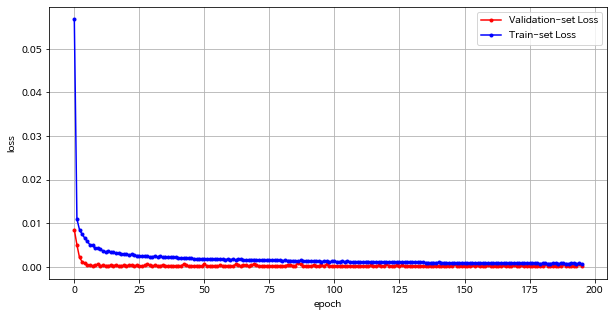

In [ ]:
# model load
gru_model.load_weights(filename)

## 위에서 분리해둔 test set에 대하여 모델 정확도 반환
print('\mean_squared_error: {:.4f}'.format(lstm_model.evaluate(test_feature, test_label))) 

y_vloss = gru_history.history['val_loss'] # 학습 중 validation loss 저장
y_loss = gru_history.history['loss'] # 학습 중 train loss 저장
x_len = np.arange(len(y_loss)) # 학습 완료 시점의 epoch 길이 저장

plt.figure(figsize=(10,5))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss") # validation loss에 대한 그래프 출력
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss") # train loss에 대한 그래프 출력
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

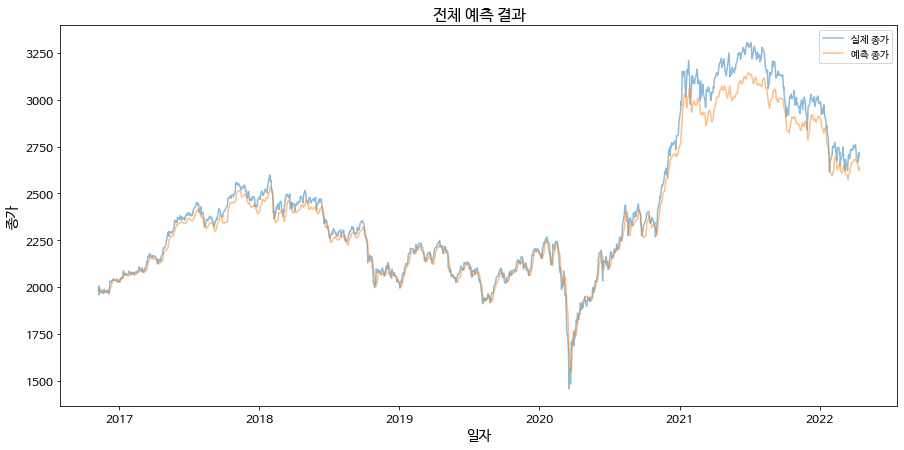

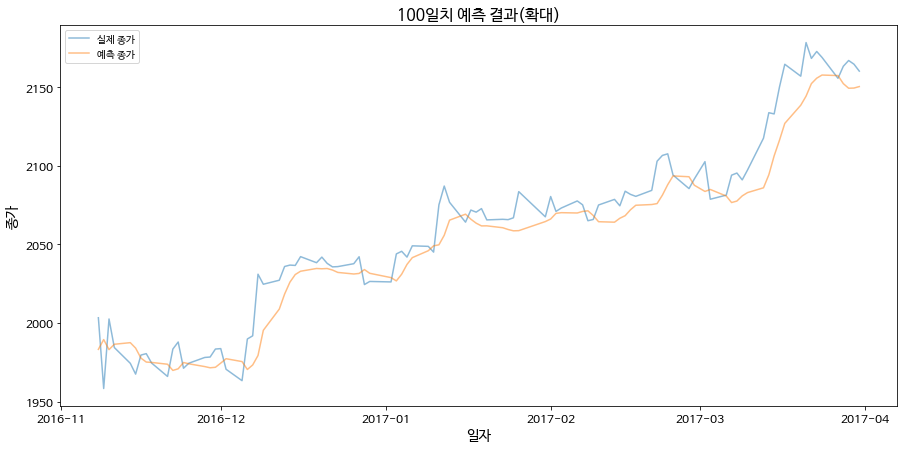

In [ ]:
# LSTM - Test set을 통한 결과 확인(test_label은 본래 test set에서 53일째부터라고 보면 됨 )

# 전체 test set에 대한 예측
date = test.reset_index(drop=True).loc[52:,'일자'].reset_index(drop=True)
real_data = pd.DataFrame(scaler_1.inverse_transform(test_label.reshape(-1,1)))
real_data = pd.concat([real_data, date],axis=1)
real_data.columns = ['실제 종가','일자']
predict_data = pd.DataFrame(scaler_1.inverse_transform(lstm_model.predict(test_feature)))
predict_data = pd.concat([predict_data, date],axis=1)
predict_data.columns = ['예측 종가','일자']

plt.figure(figsize=(15,7))
ax = sns.lineplot(data = real_data, x = '일자', y = '실제 종가', alpha=0.5)
ax1 = sns.lineplot(data = predict_data, x = '일자', y = '예측 종가', alpha=0.5)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_ylabel("종가",fontsize = 14)
ax.set_xlabel("일자",fontsize = 14)
ax.set_title("전체 예측 결과",fontsize=16)
ax.legend(['실제 종가', '예측 종가'],fontsize=10)
plt.show()

# 100일치 test set에 대한 예측 
date = test.reset_index(drop=True).loc[52:,'일자'][:100].reset_index(drop=True)
real_data = pd.DataFrame(scaler_1.inverse_transform(test_label.reshape(-1,1)[:100]))
real_data = pd.concat([real_data, date],axis=1)
real_data.columns = ['실제 종가','일자']
predict_data = pd.DataFrame(scaler_1.inverse_transform(lstm_model.predict(test_feature)[:100]))
predict_data = pd.concat([predict_data, date],axis=1)
predict_data.columns = ['예측 종가','일자']

plt.figure(figsize=(15,7))
ax = sns.lineplot(data = real_data, x = '일자', y = '실제 종가', alpha=0.5)
ax1 = sns.lineplot(data = predict_data, x = '일자', y = '예측 종가', alpha=0.5)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_ylabel("종가",fontsize = 14)
ax.set_xlabel("일자",fontsize = 14)
ax.set_title("100일치 예측 결과(확대)",fontsize=16)
ax.legend(['실제 종가', '예측 종가'],fontsize=10)
plt.show()

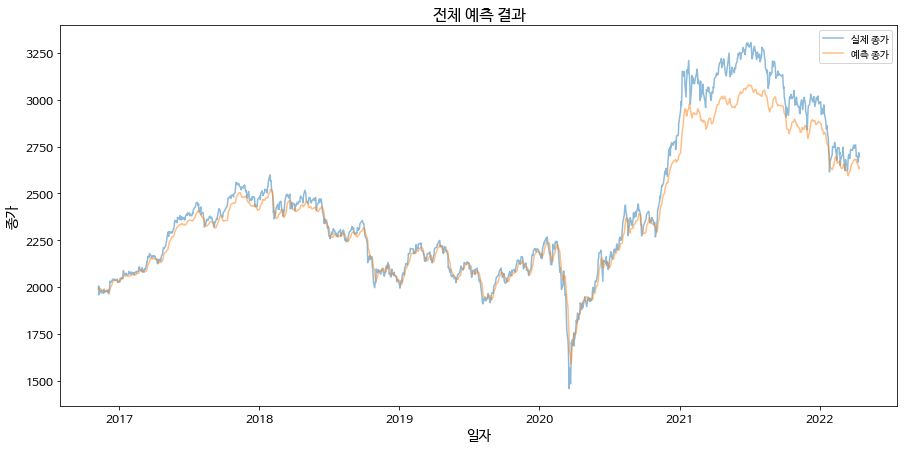

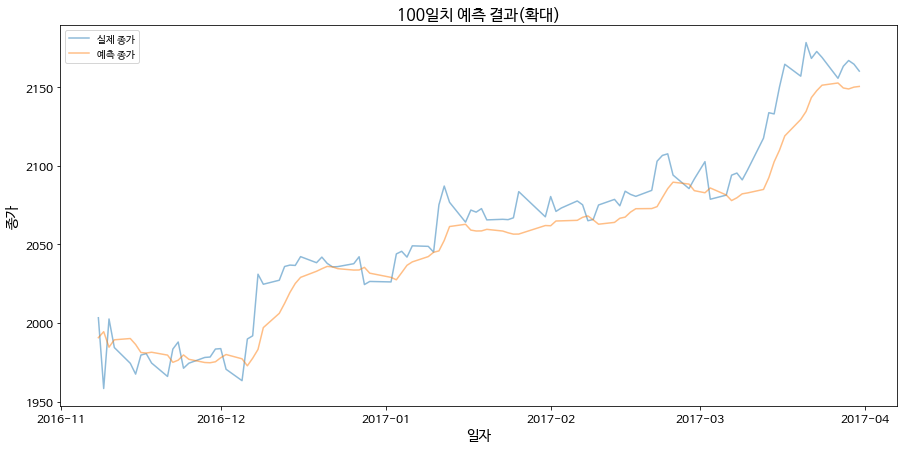

In [ ]:
# GRU - Test set을 통한 결과 확인(test_label은 본래 test set에서 53일째부터라고 보면 됨 )

# 전체 test set에 대한 예측
date = test.reset_index(drop=True).loc[52:,'일자'].reset_index(drop=True)
real_data = pd.DataFrame(scaler_1.inverse_transform(test_label.reshape(-1,1)))
real_data = pd.concat([real_data, date],axis=1)
real_data.columns = ['실제 종가','일자']
predict_data = pd.DataFrame(scaler_1.inverse_transform(gru_model.predict(test_feature)))
predict_data = pd.concat([predict_data, date],axis=1)
predict_data.columns = ['예측 종가','일자']

plt.figure(figsize=(15,7))
ax = sns.lineplot(data = real_data, x = '일자', y = '실제 종가', alpha=0.5)
ax1 = sns.lineplot(data = predict_data, x = '일자', y = '예측 종가', alpha=0.5)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_ylabel("종가",fontsize = 14)
ax.set_xlabel("일자",fontsize = 14)
ax.set_title("전체 예측 결과",fontsize=16)
ax.legend(['실제 종가', '예측 종가'],fontsize=10)
plt.show()

# 100일치 test set에 대한 예측 
date = test.reset_index(drop=True).loc[52:,'일자'][:100].reset_index(drop=True)
real_data = pd.DataFrame(scaler_1.inverse_transform(test_label.reshape(-1,1)[:100]))
real_data = pd.concat([real_data, date],axis=1)
real_data.columns = ['실제 종가','일자']
predict_data = pd.DataFrame(scaler_1.inverse_transform(gru_model.predict(test_feature)[:100]))
predict_data = pd.concat([predict_data, date],axis=1)
predict_data.columns = ['예측 종가','일자']

plt.figure(figsize=(15,7))
ax = sns.lineplot(data = real_data, x = '일자', y = '실제 종가', alpha=0.5)
ax1 = sns.lineplot(data = predict_data, x = '일자', y = '예측 종가', alpha=0.5)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_ylabel("종가",fontsize = 14)
ax.set_xlabel("일자",fontsize = 14)
ax.set_title("100일치 예측 결과(확대)",fontsize=16)
ax.legend(['실제 종가', '예측 종가'],fontsize=10)
plt.show()

* **실제 예측 결과는 과거 데이터를 1일만큼 옆으로 이동한 것과 거의 동일함**
    * 즉, 2일의 주식가격 어떻게 될 것 같은지 예측하면, 1일의 가격으로 예측하게 되는 것
    * 모델은 Loss가 가장 적도록 학습하기 때문에, 과거 패턴을 따라가도록 학습된 것으로 예상

* **해결 방안 고민**

    1) 가격이 아니라 다른 결과를 예측하게 한다면?
    
        현재 overfitting된 결과를 막기 위해 다음날의 가격이 아니라, 오를지/내릴지 binary classification으로 접근하는 방안?

    2) 가격 말고 다른 것을 함께 학습 한다면?
        거래량, SNS언급량 등 이전 시점의 가격 보다 외부 정보들에 더 의존적일 가능성이 존재함. 따라서 다양한 Input data를 수집해 보는 것 필요
    
    3) 안정 시계열 데이터 필요
        평균, 분산, 공분산이 비교적 일정한 안정 시계열이 아닌 경우 무작위 값으로 판단되어 예측 모델을 만들기가 어려움. 따라서 일별 주식 가격을 안정된 패턴을 갖는 값(변화량 등)으로 변환하여 테스트 필요 
